In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML

In [2]:
import numpy as np
import pandas as pd

import os
import pathlib

In [13]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

**Data Importing**

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!unzip /content/gdrive/MyDrive/Data-Tomato.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/Tomato_Late_blight/afb65a40-7512-4d2c-884e-56e6c5010511___RS_Late.B 5380.JPG  
  inflating: Data/Tomato_Late_blight/aff90d5c-a3f2-445a-b125-717a00b21fb8___RS_Late.B 6624.JPG  
  inflating: Data/Tomato_Late_blight/b07f5c6e-2e85-4b45-a166-522cc484619c___RS_Late.B 6276.JPG  
  inflating: Data/Tomato_Late_blight/b09b2807-58ca-4708-904e-05de3032ef92___RS_Late.B 6345.JPG  
  inflating: Data/Tomato_Late_blight/b0a1ada0-f496-46a3-827e-2d721dabee59___GHLB2 Leaf 9086.JPG  
  inflating: Data/Tomato_Late_blight/b0e6fd13-ea0c-4e04-bdd3-70878b71f353___GHLB2 Leaf 106.1.JPG  
  inflating: Data/Tomato_Late_blight/b0fbd7bd-f906-489b-96ff-a2683eb76dd3___RS_Late.B 6173.JPG  
  inflating: Data/Tomato_Late_blight/b15c92e9-6973-415c-80fe-82703ff722f7___RS_Late.B 4994.JPG  
  inflating: Data/Tomato_Late_blight/b17fad17-1d16-4a55-9b4e-d1a35ddbb611___GHLB2 Leaf 8933.JPG  
  inflating: Data/Tomato_Late_blight/b19055d9-6a5d-4b73-90a5-3b3685ac344

In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [15]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [16]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 8 5 4 7 7 0 6 4 2 0 0 6 2 9 4 1 0 8 2 7 7 1 7 4 0 9 1 7 6 2 2]


*Visualize some of the images from our dataset*

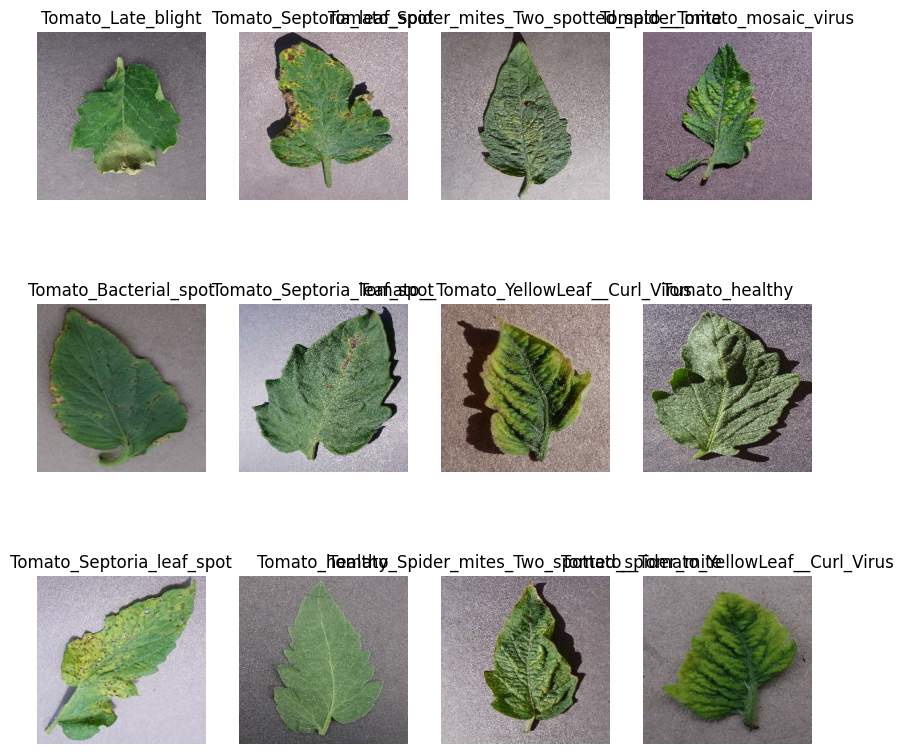

In [17]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

**Dataset Partition**
Train = 80%
test = 10%
validate = 10%

In [18]:
len(dataset)

501

In [19]:
train_size = 0.8
len(dataset)*train_size

400.8

In [20]:
train_ds = dataset.take(80)
len(train_ds)
# took 80 batches as training set

80

In [21]:
test_ds = dataset.skip(80)
len(test_ds)

421

In [22]:
val_ds = test_ds.take(10)
len(val_ds)
# took 10 batches as training set

10

In [23]:
test_ds = test_ds.skip(10).take(10)
len(test_ds)
# took 10 batches as training set

10

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [24]:
print("Train = ",len(train_ds))
print("Validation = ",len(val_ds))
print("test = ",len(test_ds))

Train =  80
Validation =  10
test =  10


# Building the Model

In [25]:
# Data Rescale and resize

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [26]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compiling the Model

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
80/80 [==============================] - 29s 361ms/step - loss: nan - accuracy: 0.1254 - val_loss: nan - val_accuracy: 0.1063
Epoch 2/20
80/80 [==============================] - 27s 340ms/step - loss: nan - accuracy: 0.1258 - val_loss: nan - val_accuracy: 0.1344
Epoch 3/20
80/80 [==============================] - 28s 346ms/step - loss: nan - accuracy: 0.1266 - val_loss: nan - val_accuracy: 0.1156
Epoch 4/20
80/80 [==============================] - 28s 343ms/step - loss: nan - accuracy: 0.1258 - val_loss: nan - val_accuracy: 0.1187
Epoch 5/20
80/80 [==============================] - 28s 346ms/step - loss: nan - accuracy: 0.1285 - val_loss: nan - val_accuracy: 0.1063
Epoch 6/20
80/80 [==============================] - 29s 355ms/step - loss: nan - accuracy: 0.1254 - val_loss: nan - val_accuracy: 0.1156
Epoch 7/20
80/80 [==============================] - 27s 339ms/step - loss: nan - accuracy: 0.1273 - val_loss: nan - val_accuracy: 0.1219
Epoch 8/20
80/80 [=======================

In [33]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 2s 30ms/step - loss: nan - accuracy: 0.1156


In [34]:
scores

[nan, 0.11562500149011612]

**Plotting the Accuracy and Loss Curves**

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 80}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch



In [38]:
type(history.history['loss'])


list

In [39]:
len(history.history['loss'])


20

In [40]:
history.history['loss'][:5] # show loss for first 5 epochs


[nan, nan, nan, nan, nan]

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

**Run prediction on a sample image**

first image to predict
actual label: Tomato_Late_blight
1/1 [==============================] - 0s 142ms/step
predicted label: Tomato_Bacterial_spot


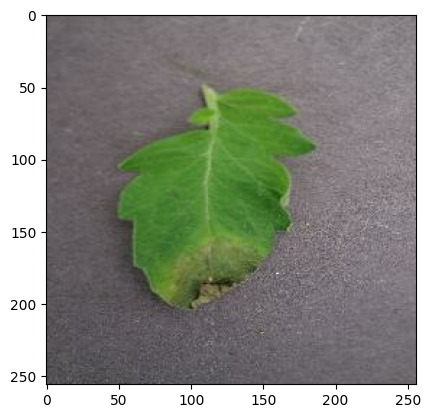

In [50]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


Write a function for inference

In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 19ms/step


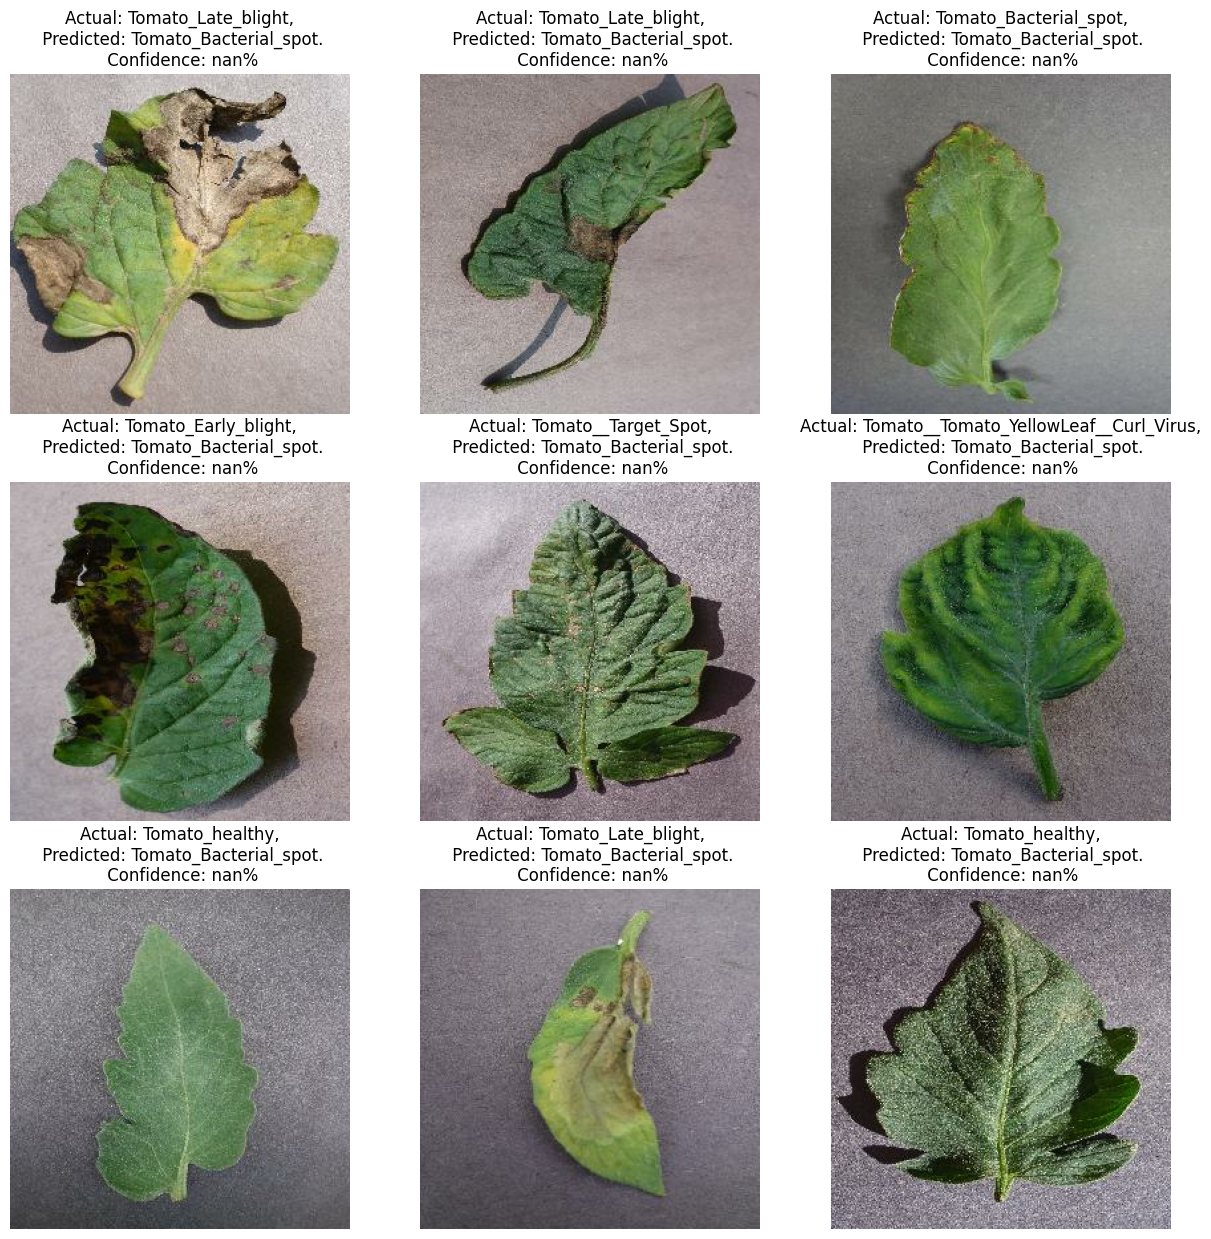

In [52]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


**Saving the Model**

In [44]:
!mkdir model

In [46]:
import os
model_version=max([int(i) for i in os.listdir("model") + [0]])+1
model.save(f"../models/{model_version}")

In [48]:
model.save("model-Tomato-Disease-Detection.h5")